# Cifar Library and Demo

[This is a library](https://pkg.go.dev/github.com/gomlx/gomlx/examples/cifar) to download and parse the Cifar datasets (Cifar-10 and Cifar-100), and a very small demo of a FNN (Feedforward Neural Network) with GoMLX. FNNs are notoriously bad for images, but it's only a demo. Look for the Resnet50 model for a more serious image classification model (old but still good -- best results as of the time of this writing is with ViT model).

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. See more details in [its homepage here](https://www.cs.toronto.edu/~kriz/cifar.html).

This notebook serves as documentation and example for the [github.com/gomlx/gomlx/examples/cifar](https://github.com/gomlx/gomlx/examples/cifar) library.

## Environment Set Up

Let's set up `go.mod` to use the local copy of GoMLX, so it can be developed jointly the dataset code with the model. That's often how data pre-processing and model code is developed together with experimentation.

If you are not changing code, feel free to simply skip this cell. Or if you used a different directory for you projects, change it below.

Notice the directory `${HOME}/Projects/gomlx` is where the GoMLX code is copied by default in [its Docker](https://hub.docker.com/repository/docker/janpfeifer/gomlx_jupyterlab/general).

In [1]:
!*rm -f go.work && go work init && go work use . "${HOME}/Projects/gomlx" "${HOME}/Projects/gonb" "${HOME}/Projects/gopjrt" "${HOME}/Projects/bsplines"
%goworkfix

	- Added replace rule for module "github.com/gomlx/bsplines" to local directory "/home/janpf/Projects/bsplines".
	- Added replace rule for module "github.com/gomlx/gomlx" to local directory "/home/janpf/Projects/gomlx".
	- Added replace rule for module "github.com/janpfeifer/gonb" to local directory "/home/janpf/Projects/gonb".
	- Added replace rule for module "github.com/gomlx/gopjrt" to local directory "/home/janpf/Projects/gopjrt".


## Data Preparation

### Downloading data files

To download, uncompress and untar to the local directory, simply do the following. Notice if it's already downloaded in the given `--data` directory, it returns immediately.

In [2]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/data"
    "github.com/janpfeifer/must"
)

var flagDataDir = flag.String("data", "~/work/cifar", "Directory to cache downloaded and generated dataset files.")

func AssertDownloaded() {
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    if !data.FileExists(*flagDataDir) {
        must.M(os.MkdirAll(*flagDataDir, 0777))
    }

    must.M(cifar.DownloadCifar10(*flagDataDir))
    must.M(cifar.DownloadCifar100(*flagDataDir))
}

%%
AssertDownloaded()

In [3]:
!ls -lh ~/work/cifar/

total 323M
drwxr-x--- 2 janpf janpf 4.0K Jul 30 10:04 base_cnn_model
drwxr-x--- 2 janpf janpf 4.0K Jul 30 09:49 base_fnn_model
drwxr-x--- 2 janpf janpf 4.0K Jul 30 09:57 base_kan_model
drwxr-xr-x 2 janpf janpf 4.0K Feb 20  2010 cifar-100-binary
-rw-r--r-- 1 janpf janpf 161M Jul  6  2023 cifar-100-binary.tar.gz
drwxr-xr-x 2 janpf janpf 4.0K Jun  4  2009 cifar-10-batches-bin
-rw-r--r-- 1 janpf janpf 163M Jul  6  2023 cifar-10-binary.tar.gz


### Sample some images

The `cifar.NewDataset` creates a `data.InMemoryDataset` that can be used both for training, evaluation, or just to sample a few examples, which we do below:

Samples Cifar-10

deer ([4]),automobile ([1]),frog ([6]),cat ([3]),frog ([6]),frog ([6]),horse ([7]),bird ([2])

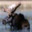
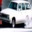
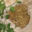
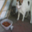
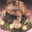
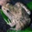
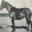
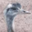

Samples Cifar-100

chair ([20]),seal ([72]),orange ([53]),pine_tree ([59]),squirrel ([80]),skyscraper ([76]),snake ([78]),lion ([43])

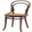
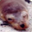
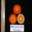
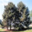
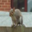
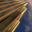
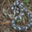
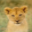

In [4]:
import (
    "strings"
    "github.com/gomlx/gopjrt/dtypes"
    "github.com/gomlx/gomlx/backends"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/types/shapes"
    "github.com/gomlx/gomlx/types/tensors/images"
    "github.com/janpfeifer/gonb/gonbui"

    _ "github.com/gomlx/gomlx/backends/xla"
)

var (
    // Model DType, used everywhere.
    DType = dtypes.Float32
    
    // Global manager, also used for all graphs.
    backend = backends.New()
)

// sampleToNotebook generates a sample of Cifar-10 and Cifar-100 in a GoNB Jupyter Notebook.
func sampleToNotebook() {
    // Load data into tensors.
    ds10 := cifar.NewDataset(backend, "Samples Cifar-10", *flagDataDir, cifar.C10, DType, cifar.Train).Shuffle()
    ds100 := cifar.NewDataset(backend, "Samples Cifar-100", *flagDataDir, cifar.C100, DType, cifar.Train).Shuffle()
    sampleImages(ds10, 8, cifar.C10Labels)
    sampleImages(ds100, 8, cifar.C100FineLabels)
}

// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleImages(ds train.Dataset, numImages int, labelNames []string) {
    gonbui.DisplayHTML(fmt.Sprintf("<p>%s</p>\n", ds.Name()))
    
    parts := make([]string, 0, numImages+5) // Leave last part empty.
    parts = append(parts, "<table><tr>")
    for ii := 0; ii < numImages; ii++ {
        _, inputs, labels := must.M3(ds.Yield())
        imgTensor := inputs[0]
        img := images.ToImage().Single(imgTensor)
        label := labels[0].Value().([]int64)
        labelStr := labelNames[label[0]]
    
        imgSrc := must.M1(gonbui.EmbedImageAsPNGSrc(img))
        size := imgTensor.Shape().Dimensions[0]
        parts = append(
            parts, 
            fmt.Sprintf(`<td><figure style="padding:4px;text-align: center;"><img width="%d" height="%d" src="%s">` + 
                        `<figcaption style="text-align: center;">%s (%d)</figcaption></figure></td>`, 
                        size*2, size*2, imgSrc, labelStr, label),
        )
    }
    parts = append(parts, "</tr></table>", "")
    gonbui.DisplayHTML(strings.Join(parts, "\n"))
}

%%
AssertDownloaded()
sampleToNotebook()

## Training on Cifar-10

### Models Support

1. `flagModel` defines the model type, out of `validModels` options.
1. `createDefaultContex` creates a context and set the default values for the CIFAR models. 
2. `contextFromSettings` uses `createDefaultContext` and incorporate changes passed by the `-set` flag.
1. `CreateDatasets` creates 3 datasets: one for training, and two for evaluation: of the training dataset and of the validation dataset.


In [5]:
import (
    "flags"
    
    "github.com/gomlx/gomlx/ml/layers"
    "github.com/gomlx/gomlx/ml/layers/fnn"
    "github.com/gomlx/gomlx/ml/layers/kan"
    "github.com/gomlx/gomlx/ml/layers/regularizers"
    "github.com/gomlx/gomlx/ml/train/commandline"
    "github.com/gomlx/gomlx/ml/train/optimizers"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
)

var (
	validModels   = []string{"fnn", "kan", "cnn", "cnn-kan"}
	flagModel     = flag.String("model", validModels[0], fmt.Sprintf("Valid model types: %v", validModels))
	flagEval      = flag.Bool("eval", true, "Whether to evaluate the model on the validation data in the end.")
	flagVerbosity = flag.Int("verbosity", 1, "Level of verbosity, the higher the more verbose.")
)

// settings is bound to a "-set" flag to be used to set context hyperparameters.
var settings = commandline.CreateContextSettingsFlag(createDefaultContext(), "set")

// createDefaultContext sets the context with default hyperparameters
func createDefaultContext() *context.Context {
	ctx := context.NewContext()
	ctx.RngStateReset()
	ctx.SetParams(map[string]any{
		"checkpoint":      "",
		"num_checkpoints": 3,
		"train_steps":     3000,

		// batch_size for training.
		"batch_size": 50,

		// eval_batch_size can be larger than training, it's more efficient.
		"eval_batch_size": 200,
		"plots":           true,

		optimizers.ParamOptimizer:           "adamw",
		optimizers.ParamLearningRate:        1e-4,
		optimizers.ParamAdamEpsilon:         1e-7,
		optimizers.ParamAdamDType:           "",
		optimizers.ParamCosineScheduleSteps: 0,
		activations.ParamActivation:         "swish",
		layers.ParamDropoutRate:             0.0,
		regularizers.ParamL2:                1e-5,
		regularizers.ParamL1:                1e-5,

		// FNN network parameters:
		fnn.ParamNumHiddenLayers: 8,
		fnn.ParamNumHiddenNodes:  128,
		fnn.ParamResidual:        true,
		fnn.ParamNormalization:   "none",

		// KAN network parameters:
		kan.ParamNumControlPoints:   10, // Number of control points
		kan.ParamNumHiddenNodes:     64,
		kan.ParamNumHiddenLayers:    4,
		kan.ParamBSplineDegree:      2,
		kan.ParamBSplineMagnitudeL1: 1e-5,
		kan.ParamBSplineMagnitudeL2: 0.0,
		kan.ParamDiscrete:           false,
		kan.ParamDiscreteSoftness:   0.1,

		// CNN
		"cnn_normalization": "layer",
	})
	return ctx
}

// CreateDatasets: train, train for evaluation and validation for evaluation.
func CreateDatasets(backend backends.Backend, dataDir string, batchSize, evalBatchSize int) (trainDS, trainEvalDS, validationEvalDS train.Dataset) {
	baseTrain := cifar.NewDataset(backend, "Training", dataDir, cifar.C10, DType, cifar.Train)
	baseTest := cifar.NewDataset(backend, "Validation", dataDir, cifar.C10, DType, cifar.Test)
	trainDS = baseTrain.Copy().BatchSize(batchSize, true).Shuffle().Infinite(true)
	trainEvalDS = baseTrain.BatchSize(evalBatchSize, false)
	validationEvalDS = baseTest.BatchSize(evalBatchSize, false)
	return
}

// ContextFromSettings is the default context (createDefaultContext) changed by -set flag.
func ContextFromSettings() *context.Context {
    ctx := createDefaultContext()
    must.M(commandline.ParseContextSettings(ctx, *settings))
    return ctx
}

// Let's test that we can set hyperparameters by setting it in the "-set" flag:
%% -set="batch_size=17;fnn_num_hidden_layers=12"
ctx := ContextFromSettings()
fmt.Printf("batch_size=%d\n", context.GetParamOr(ctx, "batch_size", -1))
fmt.Printf("fnn_num_hidden_layers=%d\n", context.GetParamOr(ctx, "fnn_num_hidden_layers", -1))

batch_size=17
fnn_num_hidden_layers=12


### Simple FNN model

A trivial model, that can easily get to ~50% accuracy (a random model would do 10%), but hardly much more than that.

Later we are going to define a CNN model to compare, and we just set a placeholder model here for now.

> **Note**: 
>
> * Cifar datasets yields (`Dataset.Yield()`) only the indices to the images of the batch as a `Tensor`. But it provides a `GatherImagesGraph` method that gathers the images from a static variable that holds the whole dataset (~1Gb in memory, stored as float32). We access it through the `getBatchedImatges()` defined above. 


In [6]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train/optimizers"
    "github.com/gomlx/gomlx/types/shapes"
)

func PlainModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
	ctx = ctx.In("model")
	batchedImages := inputs[0]
	batchSize := batchedImages.Shape().Dimensions[0]
	logits := Reshape(batchedImages, batchSize, -1)
	numClasses := len(cifar.C10Labels)
	if *flagModel == "kan" {
		// Configuration of the KAN layer(s) use the context hyperparameters.
		logits = kan.New(ctx, logits, numClasses).Done()
	} else {
		// Configuration of the FNN layer(s) use the context hyperparameters.
		logits = fnn.New(ctx, logits, numClasses).Done()
	}
	logits.AssertDims(batchSize, numClasses)
	return []*Node{logits}
}

// Only a placeholder for now.
func ConvolutionModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    return nil   
}

%% -set="batch_size=7"
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
ctx := ContextFromSettings()
g := NewGraph(backend, "placeholder")
batchSize := context.GetParamOr(ctx, "batch_size", int(100))
logits := PlainModelGraph(ctx, nil, []*Node{Parameter(g, "images", shapes.Make(DType, batchSize, cifar.Height, cifar.Width, cifar.Depth))})
fmt.Printf("Logits shape for batch_size=%d: %s\n", batchSize, logits[0].Shape())


Logits shape for batch_size=7: (Float32)[7 10]


### Training Loop

With a model function defined, let's create our training loop, with the usual bells and whistles: accuracy metrics, progress-bar, plot of metrics, checkpoints.

In [7]:
import (
    . "github.com/gomlx/exceptions"
    "github.com/gomlx/gomlx/ml/train"
    "github.com/gomlx/gomlx/examples/notebook/gonb/plotly"
)

var (
    flagCheckpoint       = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")
    flagCheckpointKeep   = flag.Int("checkpoint_keep", 10, "Number of checkpoints to keep, if --checkpoint is set.")    
)

// trainModel with hyperparameters given in ctx.
// If ctx == nil, it creates a new default context and parses settings from `-set` flag
func trainModel(ctx *context.Context) {
    if ctx == nil {
        ctx = ContextFromSettings()
    }
    // Make sure data is downloaded.
    AssertDownloaded()

	if *flagVerbosity >= 1 {
		fmt.Printf("Backend %q:\t%s\n", backend.Name(), backend.Description())
	}

	// Create datasets used for training and evaluation.
	batchSize := context.GetParamOr(ctx, "batch_size", int(0))
	if batchSize <= 0 {
		Panicf("Batch size must be > 0 (maybe it was not set?): %d", batchSize)
	}
	evalBatchSize := context.GetParamOr(ctx, "eval_batch_size", int(0))
	if evalBatchSize <= 0 {
		evalBatchSize = batchSize
	}
	trainDS, evalOnTrainDS, evalOnTestDS := CreateDatasets(backend, *flagDataDir, batchSize, evalBatchSize)

	// Create closure for model graph building function, that uses statically the dataset
	// used for its Dataset.GatherImage, to convert image indices to the actual images.
	// This is the signature of model function that the train.Trainer accepts.
	modelFn := PlainModelGraph
	if slices.Index(validModels, *flagModel) == -1 {
		Panicf("Flag --model must take one value from %v, got %q", validModels, *flagModel)
	}
	if strings.HasPrefix(*flagModel, "cnn") {
		modelFn = ConvolutionModelGraph
	}
	fmt.Printf("Model: %s\n", *flagModel)

	// Metrics we are interested.
	meanAccuracyMetric := metrics.NewSparseCategoricalAccuracy("Mean Accuracy", "#acc")
	movingAccuracyMetric := metrics.NewMovingAverageSparseCategoricalAccuracy("Moving Average Accuracy", "~acc", 0.01)

    // Read hyperparameters from context that we don't want overwritten by loading fo the context from a checkpoint.
	numTrainSteps := context.GetParamOr(ctx, "train_steps", 0)
	usePlots := context.GetParamOr(ctx, plotly.ParamPlots, false)
	
	// Checkpoints saving.
	var globalStep int
	var checkpoint *checkpoints.Handler
	if *flagCheckpoint != "" {
		checkpointPath := data.ReplaceTildeInDir(*flagCheckpoint)
		checkpoint = must.M1(checkpoints.Build(ctx).
			DirFromBase(checkpointPath, *flagDataDir).Keep(*flagCheckpointKeep).Done())
		fmt.Printf("Checkpointing model to %q\n", checkpoint.Dir())
		globalStep = int(optimizers.GetGlobalStep(ctx))
		if globalStep != 0 {
			fmt.Printf("Restarting training from global_step=%d\n", globalStep)
			ctx = ctx.Reuse()
		}
	}

	// Create a train.Trainer: this object will orchestrate running the model, feeding
	// results to the optimizer, evaluating the metrics, etc. (all happens in trainer.TrainStep)
	trainer := train.NewTrainer(backend, ctx, modelFn,
		losses.SparseCategoricalCrossEntropyLogits,
		optimizers.FromContext(ctx),
		[]metrics.Interface{movingAccuracyMetric}, // trainMetrics
		[]metrics.Interface{meanAccuracyMetric}) // evalMetrics

	// Use standard training loop.
	loop := train.NewLoop(trainer)
	if *flagVerbosity >= 0 {
		commandline.AttachProgressBar(loop) // Attaches a progress bar to the loop.
	}

	// Attach a checkpoint: checkpoint every 1 minute of training.
	if checkpoint != nil {
		period := time.Minute * 1
		train.PeriodicCallback(loop, period, true, "saving checkpoint", 100,
			func(loop *train.Loop, metrics []*tensors.Tensor) error {
				// fmt.Printf("\n[saving checkpoint@%d] [median train step (ms): %d]\n", loop.LoopStep, loop.MedianTrainStepDuration().Milliseconds())
				return checkpoint.Save()
			})
	}

	// Attach Plotly plots: plot points at exponential steps.
	// The points generated are saved along the checkpoint directory (if one is given).
	if usePlots {
		_ = plotly.New().Dynamic().
			ScheduleExponential(loop, 200, 1.2).
			WithDatasets(evalOnTrainDS, evalOnTestDS)
	}

	// Loop for given number of steps.
	if globalStep < numTrainSteps {
		_ = must.M1(loop.RunSteps(trainDS, numTrainSteps-globalStep))
		if *flagVerbosity >= 1 {
			fmt.Printf("\t[Step %d] median train step: %d microseconds\n",
				loop.LoopStep, loop.MedianTrainStepDuration().Microseconds())
		}
	} else {
		fmt.Printf("\t - target train_steps=%d already reached. To train further, set a number additional "+
			"to current global step.\n", numTrainSteps)
	}

	if *flagVerbosity >= 1 {
		var modelSize int
		var modelMemory uintptr
		if *flagVerbosity >= 2 {
			fmt.Println("Variables:")
		}
		ctx.EnumerateVariables(func(v *context.Variable) {
			if !strings.HasPrefix(v.Scope(), "/model/") {
				return
			}
			shape := v.Shape()
			if *flagVerbosity >= 2 {
				fmt.Printf("\t%s : %s - %s, %s elements, %s bytes\n", v.Scope(), v.Name(),
					shape, humanize.Comma(int64(shape.Size())), humanize.Bytes(uint64(shape.Memory())))
			}
			modelSize += shape.Size()
			modelMemory += shape.Memory()
		})
		fmt.Printf("Model size: %s elements, %s bytes\n",
			humanize.Comma(int64(modelSize)), humanize.Bytes(uint64(modelMemory)))
	}

	// Finally, print an evaluation on train and test datasets.
	if *flagEval {
		if *flagVerbosity >= 1 {
			fmt.Println()
		}
		must.M(commandline.ReportEval(trainer, evalOnTestDS, evalOnTrainDS))
	}
}

%% --model=fnn --set="train_steps=50;plots=false"
trainModel(nil)

Backend "xla":	xla:cuda - PJRT "cuda" plugin (/usr/local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.54
Model: fnn
Training (50 steps):  100% [========================================] (28 steps/s) [step=49] [loss+=2.283] [~loss+=2.359] [~loss=2.227] [~acc=17.36%]         
	[Step 50] median train step: 3801 microseconds
Model size: 510,218 elements, 2.0 MB bytes

Results on Validation:
	Mean Loss+Regularization (#loss+): 2.279
	Mean Loss (#loss): 2.147
	Mean Accuracy (#acc): 24.40%
Results on Training:
	Mean Loss+Regularization (#loss+): 2.277
	Mean Loss (#loss): 2.146
	Mean Accuracy (#acc): 24.02%


### FNN Model Training

Let's train the FNN for real this time.

In [8]:
// Remove a previously trained model. Skip this if you want to continue training a previous model.
!rm -rf ~/work/cifar/base_fnn_model  

In [9]:
%% --model=fnn --checkpoint=base_fnn_model --set="train_steps=10000;plots=true"
trainModel(ContextFromSettings())

Backend "xla":	xla:cuda - PJRT "cuda" plugin (/usr/local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.54
Model: fnn
Checkpointing model to "/home/janpf/work/cifar/base_fnn_model"


Training (10000 steps):    7% [=>......................................] (151 steps/s) [6s:1m1s] [step=719] [loss+=2.001] [~loss+=1.938] [~loss=1.809] [~acc=35.59%]         

Training (10000 steps):  100% [========================================] (190 steps/s) [step=9999] [loss+=1.485] [~loss+=1.459] [~loss=1.335] [~acc=52.75%]        

[saving checkpoint@10000] [median train step (ms): 4]


Metric: accuracy

Metric: loss

	[Step 10000] median train step: 4126 microseconds
Model size: 510,218 elements, 2.0 MB bytes

Results on Validation:
	Mean Loss+Regularization (#loss+): 1.511
	Mean Loss (#loss): 1.387
	Mean Accuracy (#acc): 50.30%
Results on Training:
	Mean Loss+Regularization (#loss+): 1.424
	Mean Loss (#loss): 1.300
	Mean Accuracy (#acc): 53.22%


### Kolmogorov-Arnold Networks (KAN) Model

A more recent alternative to FNN models. See description in https://arxiv.org/pdf/2404.19756

While it matches FNNs on the training data, it's overfitting a lot. But it saw very little hyperparameter tunning (in particular regularizations), so it is
possible it would match FNNs.

In [10]:
// Remove a previously trained model. Skip this if you want to continue training a previous model.
!rm -rf ~/work/cifar/base_kan_model  

In [11]:
%% --model=kan --checkpoint=base_kan_model --set="train_steps=10000;plots=true"
trainModel(ContextFromSettings())

Backend "xla":	xla:cuda - PJRT "cuda" plugin (/usr/local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.54
Model: kan
Checkpointing model to "/home/janpf/work/cifar/base_kan_model"


Training (10000 steps):    7% [=>......................................] (43 steps/s) [22s:3m33s] [step=719] [loss+=4.317] [~loss+=4.208] [~loss=1.890] [~acc=33.32%]        

Training (10000 steps):   22% [========>...............................] (41 steps/s) 2s:3m8s] [step=2254] [loss+=3.801] [~loss+=3.848] [~loss=1.541] [~acc=44.65%]        
[saving checkpoint@2254] [median train step (ms): 24]
Training (10000 steps):   47% [==================>.....................] (41 steps/s) 2s:2m8s] [step=4749] [loss+=3.691] [~loss+=3.628] [~loss=1.344] [~acc=51.73%]        
[saving checkpoint@4749] [median train step (ms): 24]
Training (10000 steps):   72% [===========================>............] (41 steps/s) 2s:1m8s] [step=7199] [loss+=3.251] [~loss+=3.222] [~loss=0.962] [~acc=65.67%]          
[saving checkpoint@7201] [median train step (ms): 24]
Training (10000 steps):   97% [=====================================>..] (41 steps/s) 2s:6s] [step=9729] [loss+=2.758] [~loss+=3.050] [~loss=0.810] [~acc=71.30%]          
[saving checkpoint@9731] [median train step (ms): 24]
Training (10000 steps):  100% [========================================] (40 steps/s) [step=99

Metric: accuracy

Metric: loss

	[Step 10000] median train step: 24375 microseconds
Model size: 2,514,432 elements, 10 MB bytes

Results on Validation:
	Mean Loss+Regularization (#loss+): 4.195
	Mean Loss (#loss): 1.957
	Mean Accuracy (#acc): 46.52%
Results on Training:
	Mean Loss+Regularization (#loss+): 2.934
	Mean Loss (#loss): 0.696
	Mean Accuracy (#acc): 75.25%


### CNN model for Cifar-10

Let's now properly define our CNN model to compare:

In [12]:
// normalizeImage to be used in between convolutions.
func normalizeImage(ctx *context.Context, x *Node) *Node {
	x.AssertRank(4) // [batch_size, width, height, depth]
	normalizationType := context.GetParamOr(ctx, "cnn_normalization", "none")
	switch normalizationType {
	case "layer":
		return layers.LayerNormalization(ctx, x, 1, 2).ScaleNormalization(false).Done()
	case "batch":
		return layers.BatchNormalization(ctx, x, -1).Done()
	case "none", "":
		return x
	}
	Panicf("invalid normalization type selected %q (hyperparameter %q) -- valid values are batch, layer, none", normalizationType, layers.ParamNormalization)
	return nil
}

func ConvolutionModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
	ctx = ctx.In("model")
	batchedImages := inputs[0]
	batchSize := batchedImages.Shape().Dimensions[0]
	logits := batchedImages
	{
		ctx := ctx.In("conv_0")
		logits = layers.Convolution(ctx, logits).Filters(32).KernelSize(3).Done()
		logits = normalizeImage(ctx, logits)
		logits = activations.Relu(logits)
		logits = MaxPool(logits).Window(2).Done()
	}
	{
		ctx := ctx.In("conv_1")
		logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
		logits = normalizeImage(ctx, logits)
		logits = activations.Relu(logits)
		logits = MaxPool(logits).Window(2).Done()
	}
	{
		ctx := ctx.In("conv_2")
		logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
		logits = normalizeImage(ctx, logits)
		logits = Reshape(logits, batchSize, -1)
		logits = activations.Relu(logits)
	}

	// Here logits are flat, and we can use the usual FNN/KAN.
	numClasses := len(cifar.C10Labels)
	if *flagModel == "cnn-kan" {
		// Configuration of the KAN layer(s) use the context hyperparameters.
		logits = kan.New(ctx, logits, numClasses).Done()
	} else {
		// Configuration of the FNN layer(s) use the context hyperparameters.
		logits = fnn.New(ctx, logits, numClasses).Done()
	}
	return []*Node{logits}
}

%% --set="batch_size=11"
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
g := NewGraph(backend, "test")
ctx := ContextFromSettings()
batchSize := context.GetParamOr(ctx, "batch_size", int(100))
logits := ConvolutionModelGraph(ctx, nil, []*Node{Parameter(g, "images", shapes.Make(DType, batchSize, cifar.Height, cifar.Width, cifar.Depth))})
fmt.Printf("Logits shape for batch_size=%d: %s\n", batchSize, logits[0].Shape())


Logits shape for batch_size=11: (Float32)[11 10]


### Training the CNN model

CNNs have a much better inductive bias for machine learning on images, and it can easily achieve > 80% accuracy in training data, but only > 65% on test data, due to overfitting.

Likely it would benefit from pre-training the model on a larger unlabeled datasets -- see the "Dogs vs Cats" example to see transfer learning in action for an image model.

In [15]:
!rm -rf ~/work/cifar/base_cnn_model

In [16]:
%% --model=cnn --checkpoint=base_cnn_model --set="train_steps=20000"
trainModel(nil)

Backend "xla":	xla:cuda - PJRT "cuda" plugin (/usr/local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.54
Model: cnn
Checkpointing model to "/home/janpf/work/cifar/base_cnn_model"


Training (20000 steps):    3% [>.......................................] (154 steps/s) [7s:2m5s] [step=719] [loss+=2.157] [~loss+=1.959] [~loss=1.910] [~acc=30.93%]         

Training (20000 steps):   59% [======================>.................] (219 steps/s) 2s:37s] [step=11859] [loss+=1.203] [~loss+=1.128] [~loss=1.074] [~acc=62.38%]        
[saving checkpoint@11860] [median train step (ms): 4]
Training (20000 steps):  100% [========================================] (201 steps/s) [step=19999] [loss+=0.762] [~loss+=0.791] [~loss=0.733] [~acc=74.46%]          

[saving checkpoint@20000] [median train step (ms): 4]


Metric: accuracy

Metric: loss

	[Step 20000] median train step: 4244 microseconds
Model size: 306,564 elements, 1.2 MB bytes

Results on Validation:
	Mean Loss+Regularization (#loss+): 1.510
	Mean Loss (#loss): 1.451
	Mean Accuracy (#acc): 56.30%
Results on Training:
	Mean Loss+Regularization (#loss+): 0.695
	Mean Loss (#loss): 0.636
	Mean Accuracy (#acc): 78.19%
